In [1]:
import matplotlib.pyplot as plt

from model import (
    SpotBiLSTM,
    train_model,
    find_lr,
    model_forecast,
)
from load_spot_dataset import LoadSpotDataset
from spot_dataset import SpotPriceDataset
from utils import plot_series, get_device

/Users/adf/.pyenv/versions/miniforge3-22.9.0-3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load variables from config file

## Load data

In [2]:
lsd = LoadSpotDataset("config.yaml", "data")

prices_df, instance_info_df = lsd.load_data()

In [3]:
prices_df.head()

,price_timestamp,id_instance,spot_price
0,2023-10-01 00:00:00+00:00,14500,0.2448
1,2023-10-01 00:00:00+00:00,25861,1.6511
2,2023-10-01 00:00:00+00:00,47182,0.3681
3,2023-10-01 00:00:00+00:00,11504,1.2817
4,2023-10-01 00:00:00+00:00,11923,12.5064


In [4]:
instance_info_df.head()

,region,av_zone,instance_type,instance_family,generation,modifiers,size,vcpu,memory,architectures,product_description,on_demand_price
id_instance,,,,,,,,,,,,
24406,eu-central-1,c,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
38213,eu-central-1,a,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
26575,eu-central-1,b,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
28489,eu-central-1,b,r6in.xlarge,r,6,"[i, n]",xlarge,4,32768,[x86_64],Linux/UNIX,0.41652
18475,eu-central-1,c,r6in.xlarge,r,6,"[i, n]",xlarge,4,32768,[x86_64],Linux/UNIX,0.41652


# Feature engineering and sequencing

## Feature engineering

| **Column**                | **Encoding**              | **Notes**                                                                 |
|---------------------------|---------------------------|---------------------------------------------------------------------------|
| `region_avzone`           | Embedding                 | Combine region and av_zone for better contextual encoding.                |
| `product_description`     | One-hot                   | Two values; one-hot is simpler and explicit.                              |
| `instance_family`         | Embedding                 | Embed if there are many unique families (x > 10).                         |
| `generation`              | Numerical                 | Direct mapping as ordinal (e.g., 6).                                      |
| `modifiers`                | Multi-hot encoding        | Each letter represents an independent property.                           |
| `size`                    | Numerical                 | Map sizes to integers (e.g., xlarge=1, 2xlarge=2, etc.).                  |
| `vcpu`                    | Numerical                 | Include as-is, correlated with performance.                               |
| `memory`                  | Numerical                 | Include as-is, correlated with performance.                               |
| `architectures`           | One-hot                   | Only two values; one-hot preferred for clarity.                           |


## Sequencing

Divide the training, validation and test dataframes

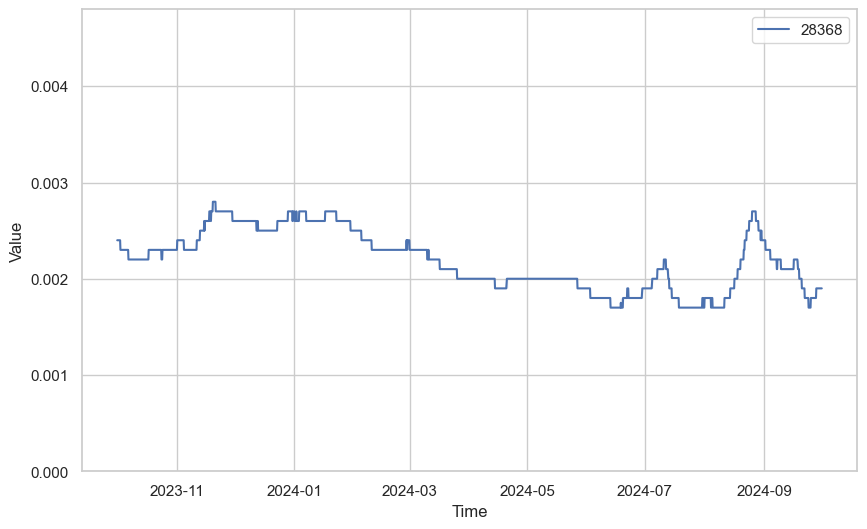

In [5]:
one_price_df = prices_df[prices_df["id_instance"] == 28368]
time = one_price_df["price_timestamp"].values
series = one_price_df["spot_price"].values
roof = instance_info_df.loc[28368, "on_demand_price"]


plot_series(time, series, roof=roof, legend=['28368'])

## Hyperparameter Tuning

In [6]:
device = get_device()

dataset_config = {
    "sequence_length": 28,
    "window_step": 4,
    "batch_size": 32
}
train_df, val_df, test_df = lsd.get_training_validation_test_split(prices_df)

train_dataset = SpotPriceDataset(train_df, dataset_config, device)
train_loader = train_dataset.get_data_loader()

val_dataset = SpotPriceDataset(val_df, dataset_config, device)
val_loader = val_dataset.get_data_loader()

### Learning Rate Range Test

In [7]:
# # Model configuration
# model_config = {
#     "hidden_size": 32,
#     "n_layers": 2,
#     "output_scale": 100.0,
#     "window_size": 20,
#     "batch_size": 32,
#     "shuffle_buffer": 1000,
#     "epochs": 100
# }
# model = SpotBiLSTM(model_config, device)


# log_lrs, losses = find_lr(model, train_loader, device)

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.grid(True)
# plt.semilogx(10**np.array(log_lrs), losses)
# plt.tick_params('both', length=10, width=1, which='both')
# plt.xlabel('Learning Rate')
# plt.ylabel('Loss')
# plt.axis([1e-8, 1e-3, 0, 30])
# plt.show()

### Model Training with Selected Learning Rate

In [ ]:
device = get_device()

model_config = {
    "hidden_size": 32,
    "n_layers": 2,
    "output_scale": 100.0,
    "window_size": 20,
    "batch_size": 128,
    "shuffle_buffer": 1000,
    "epochs": 100,
    "learning_rate": 1.33e-6,
    "optimizer": {
        "type": "SGD",
        "momentum": 0.9
    }

}
model = SpotBiLSTM(model_config, device)
history = train_model(model, train_loader, model_config, device, val_loader)

/Users/adf/.pyenv/versions/miniforge3-22.9.0-3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training for 100 epochs




Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14
Epoch [9/100] Train Loss: 0.000562 Val Loss: 0.000725 LR: 1.33e-06 │ 0:57:38 < 9:42:46



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14
Epoch [9/100] Train Loss: 0.000562 Val Loss: 0.000725 LR: 1.33e-06 │ 0:57:38 < 9:42:46
Epoch [10/100] Train Loss: 0.000515 Val Loss: 0.000781 LR: 1.33e-06 │ 1:04:44 < 9:42:43



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14
Epoch [9/100] Train Loss: 0.000562 Val Loss: 0.000725 LR: 1.33e-06 │ 0:57:38 < 9:42:46
Epoch [10/100] Train Loss: 0.000515 Val Loss: 0.000781 LR: 1.33e-06 │ 1:04:44 < 9:42:43
Epoch [11/100] Train Loss: 0.000493 Val Loss: 0.000683 LR: 1.33e-06 │ 1:11:40 < 9:39:53



Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14
Epoch [9/100] Train Loss: 0.000562 Val Loss: 0.000725 LR: 1.33e-06 │ 0:57:38 < 9:42:46
Epoch [10/100] Train Loss: 0.000515 Val Loss: 0.000781 LR: 1.33e-06 │ 1:04:44 < 9:42:43
Epoch [11/100] Train Loss: 0.000493 Val Loss: 0.000683 LR: 1.33e-06 │ 1:11:40 < 9:39:53
Epoch [12/


Training for 100 epochs

Epoch [1/100] Train Loss: 0.053370 Val Loss: 0.002183 LR: 1.33e-06 │ 0:06:41 < 0:00:00
Epoch [2/100] Train Loss: 0.001600 Val Loss: 0.001069 LR: 1.33e-06 │ 0:13:31 < 11:02:32
Epoch [3/100] Train Loss: 0.001138 Val Loss: 0.002768 LR: 1.33e-06 │ 0:20:09 < 10:51:44
Epoch [4/100] Train Loss: 0.000981 Val Loss: 0.000863 LR: 1.33e-06 │ 0:26:29 < 10:35:45
Epoch [5/100] Train Loss: 0.000831 Val Loss: 0.000819 LR: 1.33e-06 │ 0:32:26 < 10:16:15
Epoch [6/100] Train Loss: 0.000708 Val Loss: 0.000754 LR: 1.33e-06 │ 0:38:22 < 10:01:16
Epoch [7/100] Train Loss: 0.000607 Val Loss: 0.000756 LR: 1.33e-06 │ 0:44:18 < 9:48:41
Epoch [8/100] Train Loss: 0.000606 Val Loss: 0.000738 LR: 1.33e-06 │ 0:50:53 < 9:45:14
Epoch [9/100] Train Loss: 0.000562 Val Loss: 0.000725 LR: 1.33e-06 │ 0:57:38 < 9:42:46
Epoch [10/100] Train Loss: 0.000515 Val Loss: 0.000781 LR: 1.33e-06 │ 1:04:44 < 9:42:43
Epoch [11/100] Train Loss: 0.000493 Val Loss: 0.000683 LR: 1.33e-06 │ 1:11:40 < 9:39:53
Epoch [12/

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Model Evaluation

In [ ]:
test_dataset = SpotPriceDataset(test_df, dataset_config, device)

# Generate predictions
forecast_series = series[split_time-config["window_size"]:-1]
forecast = model_forecast(model, forecast_series, config["window_size"], config["batch_size"])

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Actual')
plt.plot(time_valid, forecast, label='Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics
mse = ((forecast - x_valid) ** 2).mean()
mae = abs(forecast - x_valid).mean()
print(f'MSE: {mse:.6f}')
print(f'MAE: {mae:.6f}')